# MODEL (RESNET- 50)

In [1]:
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 100.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [4]:
import pandas as pd
import os
import glob

metadata_path = "/kaggle/input/adni-data/ADNI1_Complete_1Yr_1.5T_6_20_2025.csv"
df = pd.read_csv(metadata_path)

df = df.rename(columns={
    "Image Data ID": "ImageID",
    "Subject": "SubjectID",
    "Group": "Diagnosis"
})
df = df.dropna(subset=["ImageID", "SubjectID", "Diagnosis"])
df["ImageID"] = df["ImageID"].astype(str).str.strip()
df["SubjectID"] = df["SubjectID"].astype(str).str.strip()

preprocessed_dir = "/kaggle/input/mri-preprocess-images/Preprocessed_ADNI_flat"
all_files = glob.glob(os.path.join(preprocessed_dir, "*.nii"))
imageid_to_path = {}
for path in all_files:
    fname = os.path.basename(path)
    for img_id in df["ImageID"].unique():
        if img_id in fname:
            imageid_to_path[img_id] = path
            break

print(f"Found {len(imageid_to_path)} matching NIfTI files out of {len(df)} metadata rows")

df["FilePath"] = df["ImageID"].map(imageid_to_path)
df = df.dropna(subset=["FilePath"])

label_map = {"CN": 0, "AD": 1, "MCI": 2}
df["Label"] = df["Diagnosis"].map(label_map)

df[["FilePath", "Label"]].to_csv("filtered_mri_labels.csv", index=False)
print("Saved filtered_mri_labels.csv")

Found 230 matching NIfTI files out of 2294 metadata rows
Saved filtered_mri_labels.csv


In [5]:
!pip install scikit-learn torchvision nibabel opencv-python scikit-image scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [6]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from tqdm import tqdm
from scipy.stats import entropy
from skimage.exposure import histogram
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast

In [31]:
SLICE_SIZE = 112
TOP_K = 50
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def center_crop(img, crop_size=SLICE_SIZE):
    h, w = img.shape
    if h < crop_size or w < crop_size:
        return none
    top = (h - crop_size) // 2
    left = (w - crop_size) // 2
    return img[top:top+crop_size, left:left+crop_size]

def image_entropy(img):
    hist, _ = histogram(img, nbins=256)
    hist = hist / np.sum(hist)
    return entropy(hist, base=2)

def extract_top_entropy_slices(nifti_path, top_k=TOP_K):
    data = nib.load(nifti_path).get_fdata()
    data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255
    slices = []

    for axis in range(3):
        for i in range(data.shape[axis]):
            if axis == 0:
                slice_ = data[i, :, :]
            elif axis == 1:
                slice_ = data[:, i, :]
            else:
                slice_ = data[:, :, i]

            cropped = center_crop(slice_)
            if cropped is None:
                continue

            cropped = cv2.GaussianBlur(cropped, (3, 3), 0)
            cropped = cv2.equalizeHist(cropped.astype(np.uint8))
            slices.append((image_entropy(cropped), cropped))

    slices.sort(reverse=True, key=lambda x: x[0])
    top = [cv2.resize(np.stack([s[1]] * 3, axis=-1), (SLICE_SIZE, SLICE_SIZE)) for s in slices[:top_k]]
    return top

label_map = {"CN": 0, "MCI": 1, "AD": 2}
df = pd.read_csv("/kaggle/working/filtered_mri_labels.csv")
class_counts = df['Label'].value_counts()
max_count = class_counts.max()

for label in class_counts.index:
    if class_counts[label] < max_count:
        df = pd.concat([df, df[df['Label'] == label].sample(
            max_count - class_counts[label], replace=True, random_state=42)])

all_images = []
all_labels = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    if row['Label'] not in [0, 1, 2]:
        continue
    slices = extract_top_entropy_slices(row['FilePath'], top_k=TOP_K)
    all_images.extend(slices)
    all_labels.extend([row['Label']] * len(slices))

X = np.array(all_images, dtype=np.float32) / 255.0
y = np.array(all_labels, dtype=np.int64)

100%|██████████| 363/363 [01:20<00:00,  4.49it/s]


In [26]:
class MRISliceDataset(Dataset):
    def __init__(self, images, labels, train=True):
        self.images = images
        self.labels = labels
        self.train = train
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5 if train else 0),
            transforms.RandomRotation(15 if train else 0),
            transforms.ColorJitter(brightness=0.2, contrast=0.2 if train else 0),
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)) if train else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

In [28]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = torch.tensor([class_weights[int(y)] for y in y_train], dtype=torch.float)
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_ds = MRISliceDataset(X_train, y_train, train=True)
val_ds = MRISliceDataset(X_val, y_val, train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

In [29]:
class ResNet50Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone.layer3.parameters():
            param.requires_grad = True
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, 3)
        )

    def forward(self, x):
        return self.backbone(x)

model = ResNet50Multiclass().to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(DEVICE))
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.1)
scaler = GradScaler(device="cuda")

In [32]:
best_acc = 0
best_auc = 0
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()

        with autocast(device_type="cuda"):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total

    model.eval()
    val_preds = []
    val_probs = []
    val_true = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(DEVICE)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            val_probs.extend(probs.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(y_batch.cpu().numpy())

    val_acc = accuracy_score(val_true, val_preds)
    scheduler.step(val_acc)

    print(f"Epoch {epoch}/{EPOCHS} - "
          f"Train Loss: {running_loss/len(train_loader):.4f} - "
          f"Train Acc: {train_acc:.4f} - "
          f"Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "best_resnet50_multiclass.pth")
    else:
        no_improve += 1
        if no_improve == PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

Epoch 1/50 - Train Loss: 0.4577 - Train Acc: 0.8145 - Val Acc: 0.8457
Epoch 2/50 - Train Loss: 0.4179 - Train Acc: 0.8294 - Val Acc: 0.8625
Epoch 3/50 - Train Loss: 0.3867 - Train Acc: 0.8465 - Val Acc: 0.8713
Epoch 4/50 - Train Loss: 0.3578 - Train Acc: 0.8571 - Val Acc: 0.8755
Epoch 5/50 - Train Loss: 0.3216 - Train Acc: 0.8757 - Val Acc: 0.8840
Epoch 6/50 - Train Loss: 0.3034 - Train Acc: 0.8842 - Val Acc: 0.8948
Epoch 7/50 - Train Loss: 0.2730 - Train Acc: 0.8937 - Val Acc: 0.8986
Epoch 8/50 - Train Loss: 0.2717 - Train Acc: 0.8950 - Val Acc: 0.9094
Epoch 9/50 - Train Loss: 0.2402 - Train Acc: 0.9103 - Val Acc: 0.8992
Epoch 10/50 - Train Loss: 0.2350 - Train Acc: 0.9108 - Val Acc: 0.9182
Epoch 11/50 - Train Loss: 0.2177 - Train Acc: 0.9191 - Val Acc: 0.9165
Epoch 12/50 - Train Loss: 0.2136 - Train Acc: 0.9194 - Val Acc: 0.9245
Epoch 13/50 - Train Loss: 0.1976 - Train Acc: 0.9272 - Val Acc: 0.9328
Epoch 14/50 - Train Loss: 0.1818 - Train Acc: 0.9325 - Val Acc: 0.9416
Epoch 15/50 - T

In [33]:
model.load_state_dict(torch.load("best_resnet50_multiclass.pth"))
model.eval()

final_preds = []
final_true = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        final_preds.extend(preds.cpu().numpy())
        final_true.extend(y_batch.cpu().numpy())

print("\nFinal Evaluation:")
print(classification_report(final_true, final_preds, target_names=["CN", "MCI", "AD"]))
print(f"Best Validation Accuracy: {best_acc:.4f}")


Final Evaluation:
              precision    recall  f1-score   support

          CN       0.98      0.98      0.98      1210
         MCI       0.99      1.00      0.99      1210
          AD       0.98      0.97      0.98      1210

    accuracy                           0.98      3630
   macro avg       0.98      0.98      0.98      3630
weighted avg       0.98      0.98      0.98      3630

Best Validation Accuracy: 0.9851


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix


Per-class ROC AUC Scores (One-vs-Rest):
CN: AUC = 0.9992
MCI: AUC = 0.9995
AD: AUC = 0.9991


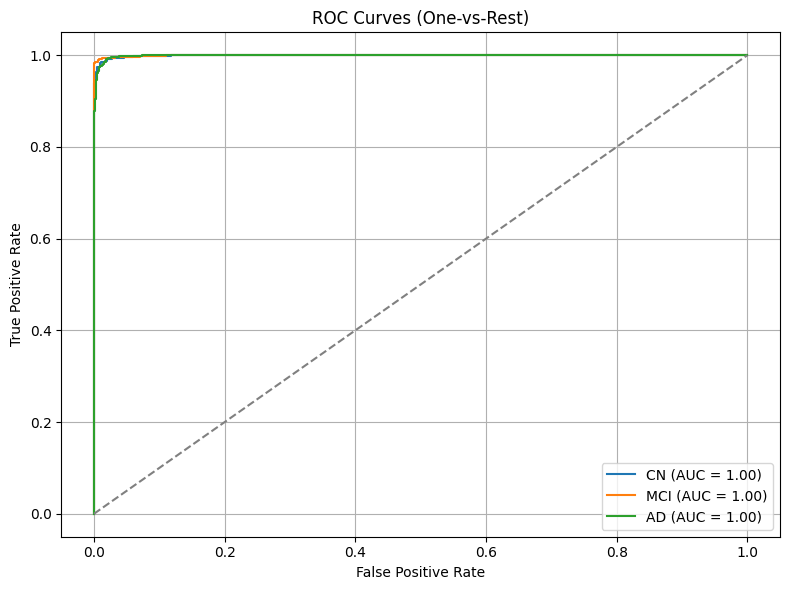

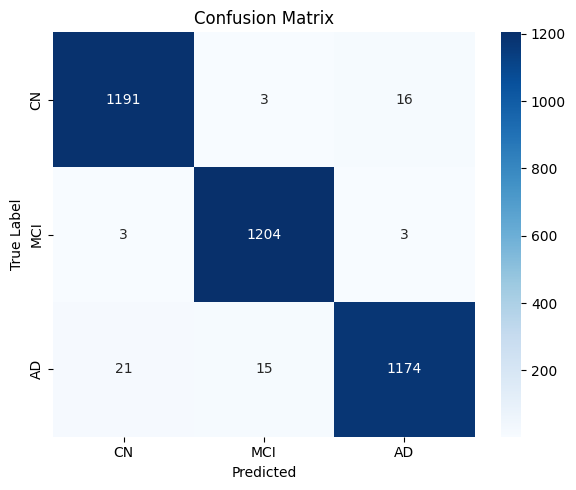

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# AUC
val_probs = np.array(val_probs)  
val_true_onehot = np.eye(3)[final_true]  

print("\nPer-class ROC AUC Scores (One-vs-Rest):")
for i, label in enumerate(["CN", "MCI", "AD"]):
    auc_score = roc_auc_score(val_true_onehot[:, i], val_probs[:, i])
    print(f"{label}: AUC = {auc_score:.4f}")

# ROC curves
plt.figure(figsize=(8, 6))
for i, label in enumerate(["CN", "MCI", "AD"]):
    fpr, tpr, _ = roc_curve(val_true_onehot[:, i], val_probs[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(val_true_onehot[:, i], val_probs[:, i]):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(final_true, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["CN", "MCI", "AD"], yticklabels=["CN", "MCI", "AD"])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()